# Example SciDB queries for trade and quote data

This iPython Notebook achieves the following:
 - Loading NYSE market data
 - Bar building (open high low close)
 - Building minute bars
 - Calculating VWAP
 - As-Of join
 - Running ad-hoc queries (e.g. checking for Regulation NMS/Compliance)

The most updated version of this code is maintained at https://github.com/Paradigm4/TAQ

# Download the data

 - This notebook uses NYSE market made available from http://www.nyxdata.com/ 
 - The data file format specification is available from: http://www.nyxdata.com/doc/224904
 - The data license governs that we cannot redistribute the data as part of this AMI. Hence the first step is to download the data via FTP. 
 - Download speed vary. 
     - You can hit `play` on the two cells below one after the other, they will execute sequentially
     - The ETA for the first file (`quotes`) will be printed soon after you start the download
     - The second file (`trades`) is ~1/7-th the size, hence download is that much faster

## A few minutes for the download...
 - We wanted to show SciDB operations on real market data... just a few minutes till the download completes (the `wget` command will print the ETA)
 - We will start with analysis using SciDB right after
 - Till that time, you can read and view the prestored results of subsequent cells.


In [1]:
!wget ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_NBBO_20131218.zip \
    --directory-prefix=/tmp   

--2016-04-11 21:25:22--  ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_NBBO_20131218.zip
           => ‘/tmp/EQY_US_ALL_NBBO_20131218.zip’
Resolving ftp.nyxdata.com (ftp.nyxdata.com)... 159.125.78.28
Connecting to ftp.nyxdata.com (ftp.nyxdata.com)|159.125.78.28|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Historical Data Samples/Daily TAQ ... done.
==> SIZE EQY_US_ALL_NBBO_20131218.zip ... 2113968509
==> PASV ... done.    ==> RETR EQY_US_ALL_NBBO_20131218.zip ... done.
Length: 2113968509 (2.0G) (unauthoritative)

100%[====================================>] 2,113,968,509 3.64MB/s   in 10m 2s 

2016-04-11 21:35:24 (3.35 MB/s) - ‘/tmp/EQY_US_ALL_NBBO_20131218.zip’ saved [2113968509]



In [2]:
!wget ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_TRADE_20131218.zip \
    --directory-prefix=/tmp   

--2016-04-11 21:35:25--  ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_TRADE_20131218.zip
           => ‘/tmp/EQY_US_ALL_TRADE_20131218.zip’
Resolving ftp.nyxdata.com (ftp.nyxdata.com)... 159.125.78.28
Connecting to ftp.nyxdata.com (ftp.nyxdata.com)|159.125.78.28|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Historical Data Samples/Daily TAQ ... done.
==> SIZE EQY_US_ALL_TRADE_20131218.zip ... 312753367
==> PASV ... done.    ==> RETR EQY_US_ALL_TRADE_20131218.zip ... done.
Length: 312753367 (298M) (unauthoritative)

100%[======================================>] 312,753,367 3.98MB/s   in 75s    

2016-04-11 21:36:40 (3.95 MB/s) - ‘/tmp/EQY_US_ALL_TRADE_20131218.zip’ saved [312753367]



# Loading the data into ScIDB

The `trades_load.sh` and `trades_redim.sh` scripts load the `EQY_US_ALL_TRADE_20131218.zip` data and redimensions it into a `ms` (time) by `symbol_index` by `synthetic` 3-d SciDB array. 

The script also creates an auxiliary mapping array named `tkr` between string ticker symbol and integer symbol index.

The `quotes_load.sh` and `quotes_redim.sh` script does the same thing but for the `EQY_US_ALL_NBBO` quote data file.

## Note on loaders

The loaders shown above use the most generic loaders available in SciDB community edition. SciDB can achieve much higher load rates using Enterprise edition plugins.  

## Steps to load `trades` data

 - Run the following to load and redimension the example data
 - For a first run, we load the first 500k elements of the `trades` data. 
 - Later, we suggest that you let the entire load run (by commenting / uncommenting the appropriate line below)

In [3]:
import subprocess
proc = subprocess.Popen(["./trades_load.sh", "/tmp/EQY_US_ALL_TRADE_20131218.zip", "500000"], stdout=subprocess.PIPE)
# proc = subprocess.Popen("./trades_load.sh", stdout=subprocess.PIPE)
output1 = proc.stdout.read()
proc = subprocess.Popen("./trades_redim.sh", stdout=subprocess.PIPE)
output2 = proc.stdout.read()
print(output1 + '\n' + output2)

Query was executed successfully
Query was executed successfully
Query was executed successfully
Query was executed successfully

Query was executed successfully
{i} count
{0} 39
Query was executed successfully
Query was executed successfully



## Steps to load `quotes` data

 - Again, for a first run, we load the first 1M elements of the `quotes` data
 - Later, we suggest that you load the entire `quotes` data (by commenting / uncommenting the appropriate line below)
     - ETA: 10 minutes for loading entire day

In [4]:
proc = subprocess.Popen(["./quotes_load.sh", "/tmp/EQY_US_ALL_NBBO_20131218.zip",  "1000000"], stdout=subprocess.PIPE)
# proc = subprocess.Popen("./quotes_load.sh", stdout=subprocess.PIPE)
output1 = proc.stdout.read()
proc = subprocess.Popen("./quotes_redim.sh", stdout=subprocess.PIPE)
output2 = proc.stdout.read()
print(output1 + '\n' + output2)

Query was executed successfully
Query was executed successfully
Query was executed successfully

Query was executed successfully
Query was executed successfully



# Connecting to the database

Then let's run some queries on the loaded trades and quote (TAQ) data directly from the Python interface.
First let us set up the connectivity to the database (and also import some useful libraries)

In [5]:
import matplotlib.pyplot as plt
from scidbpy import connect
import time
sdb = connect("http://localhost:8080")
afl = sdb.afl

Next, associate Python objects with SciDB arrays (no data transfers yet -- just connections)

In [6]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

An example lookup

In [7]:
if subprocess.call(["/opt/scidb/15.12/bin/iquery", "-aq", "load_library('limit')"]) == 0:
    print('loaded library: limit')
else:
    print('''requires user to install the `limit` library. 
            See https://github.com/Paradigm4/limit. 
            Otherwise, use the slower version: tkr.todataframe().head()''')
tkr.limit(5).todataframe() 

loaded library: limit


,symbol
symbol_index,
0,A
1,AA
2,AA PR
3,AADR
4,AAIT


# Looking up trades by symbol string

Join with the auxiliary `tkr` array to look up data by ticker symbol name. Here are examples that count the number of trades and quotes for 'ABBV'.


In [8]:
symbol = "ABBV"
print("%d trades for %s " % (sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty(), symbol))
print("%d quotes for %s " % (sdb.merge(quotes,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty(), symbol))

56545 trades for ABBV 
89867 quotes for ABBV 


As expected we see more quotes than trades for this instrument. 

The above join showed us that there are 56545 trades for the ticker `ABBV`. We can also retrieve those trades using the `between` statement, but we need to know the `symbol_index`, which we find by:

In [9]:
tkr.filter("symbol='%s'" % symbol).todataframe()

,symbol
symbol_index,
22,ABBV


We find the dimensions of the array trades as:

In [10]:
trades.dim_names

[u'synthetic', u'symbol_index', u'tm']

And we then run the `between` statement using the following syntax:

In [11]:
trades.between('null', 22, 'null', 'null', 22, 'null').nonempty()

56545

The order of arguments follows the dimensions of the array:
 - the `trades` array has three dimensions (`synthetic, symbol_index, tm`)
 - the `between` expects pairs of arguments for `[start, end]`
 - hence six arguments for the `between` command above

# Computing VWAP

Let's turn to another common kind of operation, computing volume-weighted average price (VWAP). We'll compute it for every instrument across their raw trade data in the array trades, and store the result into a new array called 'VWAP'.

In [12]:
vwap = trades.apply('pv', 'price*volume')
vwap = sdb.afl.cumulate(vwap, \
                        'sum(pv) as numerator', \
                        'sum(volume) as denominator', 'tm')
vwap = vwap.apply('vwap', 'numerator/denominator')
sdb.merge(vwap, tkr[tkr == 'AAPL']).\
    limit(5).\
    todataframe()

numerator  denominator        vwap symbol
synthetic symbol_index tm                                                 
0         13           14781433     2780.0            5  556.000000   AAPL
                       14833032    58375.0          105  555.952381   AAPL
                       15477542   169209.0          305  554.783607   AAPL
                       15643058   224698.0          405  554.809877   AAPL
                       15689610   502008.0          905  554.704972   AAPL

# Computing minute bars

The trade data are now organized by symbol, time, and a synthetic coordinate that separates collisions (due to, say exchanges) in a sparse array.

We need some extra aggregates from the `axial_aggregate` plugin -- load that:

## Load `axial_aggregate` library

We load the `axial_aggregate` library for the following calculations. The library is only available to Enterprise customers. Contact Paradigm4 for more details.

In [13]:
if subprocess.call(["/opt/scidb/15.12/bin/iquery", "-aq", "load_library('axial_aggregate')"]) !=0: 
    print('The library is only available to Enterprise customers. Contact Paradigm4 for more details. ')

The following query computes and store one-minute open/high/low/close bars from these data. 

In [14]:
minute_bars = trades.apply('timeprice', 'tuple(tm,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.eval()

Note that the calculation was done for all the tickers in parallel. 

We then download all the minute-bars data for ticker `AAN` into a Pandas dataframe. This shows the capability to download data into Python. 

In [15]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == "AAN"]).todataframe()
mb1.head()

open   high    low   close symbol
synthetic symbol_index tm                                     
0         9            570  28.89  28.97  28.73  28.730    AAN
                       571  28.96  28.96  28.87  28.870    AAN
                       572  28.80  28.84  28.73  28.815    AAN
                       573  28.80  28.80  28.80  28.800    AAN
                       574  28.83  28.83  28.73  28.730    AAN

Note! That 570 minutes = 9:30 AM.

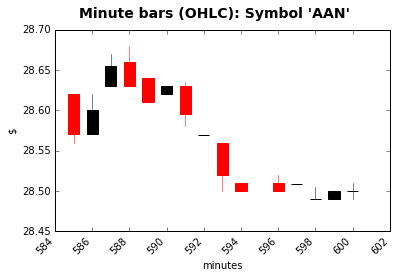

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2,l3 = zip(*mb1.index.get_values())
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l3, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars (OHLC): Symbol \'AAN\' ', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

# AsOf join

The `asof` operator joins trade data with quote data. At time points where quote data is not available, the last known value is looked up and filled in. This is sometimes also called a 'last value carry forward' join or 'piecewise constant interpolation join'.

The syntax is:
```
asof(A, B [, aggrDim [, missingCode [, preserveNull]])
```

where the inputs are:
- `A & B`: two arrays that have the same dimensionality;
- `aggrDim`: the dimension in A along which to find last_value. Default is the last dimension.
- `missingCode`: the missing code to use, when an A record cannot be found. Default is 0.
- `preserveNull`: whether to preserve or skip past nulls in the left array. Default is to preserve.

Before we run the `asof` join, we have to take care of collisions in the timestamp dimension. Times were recorded in milliseconds and there were quite a lot of collisions in the data, as shown by the partial result below. 

In [17]:
quotes.aggregate('count(*)', 'synthetic').todataframe().tail()

,count
synthetic,
44,3
45,3
46,1
47,1
48,1


The above result shows that there are up to 48 collisions at a certain timestamp for the loaded data. 

We can take care of the synthetic dimensions in multiple ways. In this example, we choose to convert the millisecond timestamp to an artificial microsecond resolution. 

## Taking care of synthetics in the quotes array 

We first find the minimum sequence number at each symbol index and timestamp

In [18]:
minseq = quotes.aggregate('min(sequence_number)', 'symbol_index', 'tm')

We then join it back with the quotes array

In [19]:
joined = sdb.merge(quotes, minseq)

Finally, we calculate an ordered index at each colliding timestamp, and then redimension to an array that has an artifical but correctly ordered microsecond timestamp resolution.

In [20]:
quotes2 = joined.apply('subi', 'sequence_number - sequence_number_min')\
            .apply('tm_us', 'tm*1000 + subi')\
            .redimension('''<tm:int64, ask_price:double,ask_size:int64,
                         bid_price:double,bid_size:int64,sequence_number:int64,
                         condition:string,exchange:string>
                         [symbol_index=0:*,10,0, tm_us=0:*,86400000000,0]''')
quotes2 = quotes2.eval()

Next we do the same to the trades array, but we add an offset of 500 to the artificial microsecond timestamp dimension. That means we can handle upto 499 collisions at any millisecond in our new artificial timestamp dimension

In [21]:
minseq = trades.aggregate('min(sequence_number)', 'symbol_index', 'tm')
joined = sdb.merge(trades, minseq)
trades2 = joined.apply('subi', 'sequence_number - sequence_number_min')\
            .apply('tm_us', 'tm*1000 + 500 + subi')\
            .redimension('''<tm:int64, price:double,volume:int64,
                            sequence_number:int64,condition:string,
                            exchange:string>
                         [symbol_index=0:*,10,0, tm_us=0:*,86400000000,0]''')
trades2 = trades2.eval()

Finally we run the `asof` join and make some simple checks:

In [22]:
asof1 = sdb.afl.asof('%s as A' % quotes2.name, trades2, 'A.tm_us', 5, 'false')
asof1 = asof1.eval()

In [23]:
print('\n# of elements in the joined result:')
print(asof1.nonempty())
print('\nThe head() of the joined array')
sdb.merge(asof1.project('tm', 'ask_price', 'ask_size', 'bid_price', 'bid_size', 'tm_2', 'price', 'volume'), \
            tkr[tkr == 'AAN']).\
            limit(20).\
            todataframe().tail()


# of elements in the joined result:
499999

The head() of the joined array


tm  ask_price  ask_size  bid_price  bid_size  \
symbol_index tm_us                                                             
9            34232777504  34232777      28.97         1      28.66         1   
             34232785500  34232777      28.97         1      28.66         1   
             34232863500  34232863      28.93         1      28.81         1   
             34233100500  34233100      29.10         5      28.81         2   
             34234165500  34233768      29.10         5      28.68         1   

                              tm_2  price  volume symbol  
symbol_index tm_us                                        
9            34232777504  34232777  28.92     100    AAN  
             34232785500  34232785  28.92     700    AAN  
             34232863500  34232863  28.86     100    AAN  
             34233100500  34233100  28.81     200    AAN  
             34234165500  34234165  28.73     100    AAN

# RegNMS (Compliance)

Finally run some interesting analysis on the result of the As Of join. 

First, filter the joined quotes for inconsistencies e.g. where the ask price was lower than the bid price. 

In [24]:
sdb.merge(asof1.filter('ask_price < bid_price')\
        .project('tm', 'ask_price', 'ask_size', 'bid_price', 'bid_size', 'tm_2', 'price', 'volume'), \
        tkr[tkr=='AAN'])\
        .limit(5)\
        .todataframe()

,,tm,ask_price,ask_size,bid_price,bid_size,tm_2,price,volume,symbol
symbol_index,tm_us,,,,,,,,,


Thus there are no inconsistent quotes.

Next, check for trades that occurred outside the ask-bid spread. 

In [25]:
sdb.merge(asof1.filter('price < bid_price or price > ask_price')\
        .project('tm', 'ask_price', 'ask_size', 'bid_price', 'bid_size', 'tm_2', 'price', 'volume'), \
        tkr[tkr=='AAN']).\
        limit(5).\
        todataframe()

tm  ask_price  ask_size  bid_price  bid_size  \
symbol_index tm_us                                                             
9            34320455500  34319040      28.87         1      28.82         2   
             34655487500  34655486      28.74         4      28.67         3   
             34659620500  34658346      28.70         6      28.63         1   
             34665843500  34665843      28.70         1      28.68         1   
             34672609500  34672603      28.74         1      28.72         1   

                              tm_2   price  volume symbol  
symbol_index tm_us                                         
9            34320455500  34320455  28.800     100    AAN  
             34655487500  34655487  28.750     100    AAN  
             34659620500  34659620  28.725     900    AAN  
             34665843500  34665843  28.670      96    AAN  
             34672609500  34672609  28.760     600    AAN

Above, we found some joined results where the traded price lies outside the range between bids and asks. 

# Not shown here

Using these same building blocks of array storage, multidimensional joins, linear algebra, R/Python interfaces and advanced extensibility, SciDB can perform a vast universe of various tasks, all of which would simply not fit into a single AMI. Here’s a partial list of other analyses we have performed together with some of our customers and partners:

1. Customized load scripts
     - Parallel binary load: Parallel ingest of files located across the storage cluster
     - Domain specific loader modules: Loaders optimized for specific data-type that is to be ingested
2. Order book building
     - Order book building from TAQ data
     - Order book aggregation (NBBO) from multiple books
3. Other finance workflows
     - Portfolio risk analysis
     - Transaction cost analysis
     - Advanced tick analytics
     - Bi-temporal data handling
     - Option volatility surface studies
4. Interfacing with compute grids
     - Parallel download to 3rd party clients (Python, R) to support elastic compute grids 
5. Enterprise-Level Features
     - Elasticity: adding new nodes to a live cluster with negligible downtime. The data can be redistributed while the cluster remains available for queries.
     - Namespaces and Permissions: granting certain database users permissions over specific arrays - to control access and share more effectively and securely.
     - Replication: storing extra copies of data to protect against disk failure. 
     - System monitoring: a mechanism that detects the loss of a host and, if the failure is intermittent, automatically returns the system to working state
6. Additional functionality: large sparse SVD, GLM, MKL-accelerated linear algebra

For questions about any of these, items reach out to us at `FinancialMarkets@paradigm4.com`.
